## Covid Detection using Chest Scan

## General flow of model 

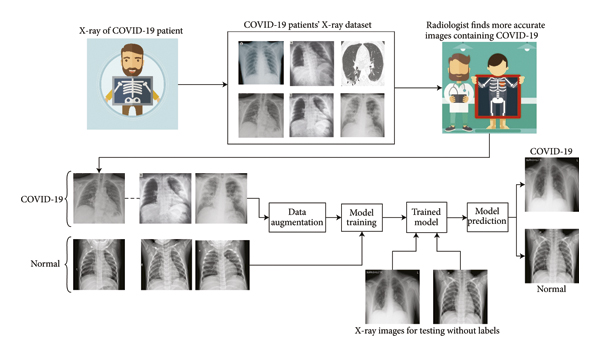

## 1.Importing Libraries

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

## 2. Building Model

In [2]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                    

## Rescaling image into defined shape

In [3]:
# 1.image.ImageDataGenerator is a class provided by the tensorflow.keras.preprocessing.image module.

train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         horizontal_flip = True,
                                         zoom_range = 0.2)

val_datagen = image.ImageDataGenerator(rescale=1./255)

In [4]:
training_data = train_datagen.flow_from_directory('Train',
                                                  target_size=(224,224),
                                                  class_mode='binary',
                                                  batch_size=32)

val_data = val_datagen.flow_from_directory('Val',
                                           target_size=(224,224),
                                           class_mode='binary',
                                           batch_size=32)

Found 282 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [5]:
training_data.class_indices # class indiacation

{'COVID': 0, 'NORMAL': 1}

## 3. Model Fitting

In [7]:
e = 20   # number of Iteration on training data.
hist = model.fit(training_data,
                    steps_per_epoch=8,
                    epochs = e,
                    validation_data = val_data,
                    validation_steps = 2)


Epoch 1/20
8/8 [==============================] - 31s 4s/step - loss: 0.9374 - accuracy: 0.5640 - val_loss: 0.6916 - val_accuracy: 0.8750
Epoch 2/20
8/8 [==============================] - 31s 4s/step - loss: 0.6768 - accuracy: 0.6200 - val_loss: 0.6562 - val_accuracy: 0.7656
Epoch 3/20
8/8 [==============================] - 31s 4s/step - loss: 0.5544 - accuracy: 0.7600 - val_loss: 0.4147 - val_accuracy: 0.8594
Epoch 4/20
8/8 [==============================] - 33s 4s/step - loss: 0.3543 - accuracy: 0.8440 - val_loss: 0.2545 - val_accuracy: 0.8750
Epoch 5/20
8/8 [==============================] - 32s 4s/step - loss: 0.2309 - accuracy: 0.8960 - val_loss: 0.1579 - val_accuracy: 0.9375
Epoch 6/20
8/8 [==============================] - 34s 4s/step - loss: 0.1931 - accuracy: 0.9360 - val_loss: 0.1417 - val_accuracy: 0.9531
Epoch 7/20
8/8 [==============================] - 32s 4s/step - loss: 0.1420 - accuracy: 0.9440 - val_loss: 0.1132 - val_accuracy: 0.9688
Epoch 8/20
8/8 [==================

### Accuracy Achieved By Model is ---> 97.2 %

## 4. Saving Model

In [ ]:
# model.save('../models/covid.h5')

## Plots of Accuracy and Loss

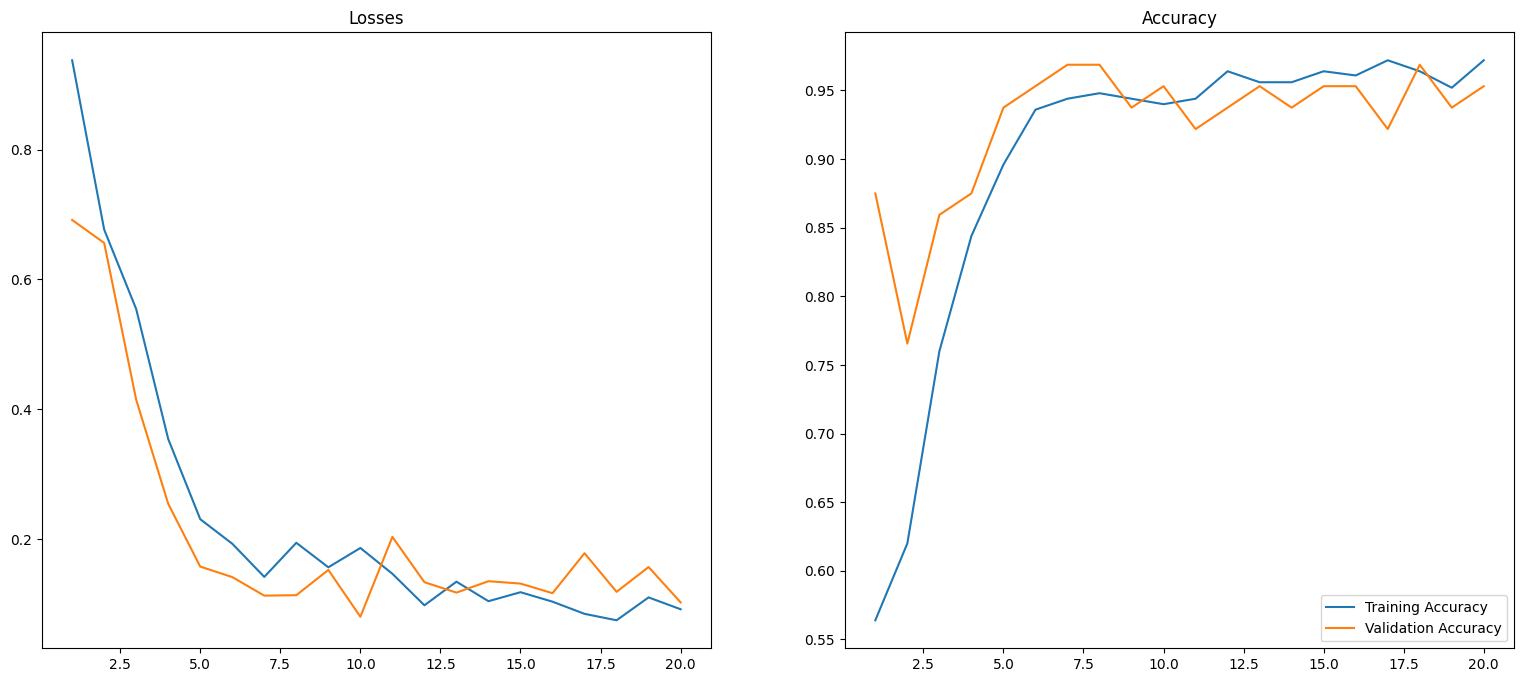

In [8]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(1,e+1)

plt.figure(figsize=(19,8))
plt.subplot(121)
plt.plot(epochs,train_loss,label='Training loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.title('Losses')

plt.subplot(122)
plt.plot(epochs,acc,label='Training Accuracy')
plt.plot(epochs,val_acc,label='Validation Accuracy')
plt.title('Accuracy')

plt.legend()

In [ ]:
model.evaluate_generator(training_data)

In [ ]:
model.evaluate_generator(val_data)

## Testing the Model

In [ ]:
import cv2
import os
import seaborn as sns
from tensorflow.keras.models import load_model

TP = 0
TN = 0
FP = 0
FN = 0

model = load_model('../models/covid.h5')   # loading saved model

covid_images = os.listdir('Test/COVID')    # loading test dataset for positive detection
normal_images = os.listdir('Test/NORMAL')  # loading test dataset for negative / normal detection

for i in covid_images:
    img = cv2.imread('Test/COVID/'+i)
    img = cv2.resize(img, (224, 224))   # resizing the image
    img = img.reshape(1, 224, 224, 3)   # reshaping the image
    img = img/255.0                     # rescaling the image into 0 and 1 
    pred = model.predict(img)  
    if pred < 0.5:
        TP+=1
    else:
        FN+=1

for i in normal_images:
    img = cv2.imread('Test/NORMAL/'+i)
    img = cv2.resize(img, (224, 224))
    img = img.reshape(1, 224, 224, 3)
    img = img/255.0
    pred = model.predict(img)
    if pred > 0.5:
        TN+=1
    else:
        FP+=1
  
sns.heatmap([[TP,FP],[FN,TN]],annot=True)